Copyright notice:
    created by Adam+Claude based on tasks by Agata

# DeepWalk: Mathematical Formulation and Implementation
This is arguably a simplified version that shows the core ideas, but all the formulations differ from the original papers.

Also it focuses on an encoder-decoder explicit design for educational purposes, which is arguable. 

Specifically, the paper defines the problem very differently. Instead of just describing random walks and skip-gram, it sets up:

- The formal problem definition as a classification task on a social network G=(V,E):
```
Members V with attributes X ∈ R^(|V|×S)
Labels Y ∈ R^(|V|×|Y|)
Goal: Learn embeddings XE ∈ R^(|V|×d) where d is small
```

- The learning objective from the paper:
```
CopyPr(vi | Φ(v1), Φ(v2), ..., Φ(vi-1))
This aims to predict vertex vi given all previous vertices in the walk, where Φ maps vertices to their latent representations.
```
- The relaxed optimization problem:
```
minimize -log Pr({vi-w, ..., vi-1, vi+1, ..., vi+w} | Φ(vi))
```

The paper also describes implementation details:

- Learning rate α starts at 2.5% and decreases linearly
- Uses Hierarchical Softmax with Huffman coding for efficient training
- Has a binary tree T of parameters for the hierarchical softmax

Word2Vec https://arxiv.org/abs/1301.3781
DeepWalk https://arxiv.org/pdf/1403.6652
Node2Vec https://arxiv.org/abs/1607.00653

## 1. Random Walk Generation

Given a graph $G=(V,E)$, DeepWalk generates multiple random walks starting from each vertex. Let's break this down:

### Single Walk Definition
For any starting vertex $v_i \in V$, a single random walk of length $l$ is defined as:

$W_{v_i} = (w_1^i, w_2^i, ..., w_l^i)$ where:
- $w_1^i = v_i$ (start node)
- $w_{j+1}^i \sim P(v|w_j^i)$ (transition probability)
- $P(v|w_j^i) = \begin{cases} 
    \frac{1}{deg(w_j^i)} & \text{if } (w_j^i,v) \in E \\
    0 & \text{otherwise}
  \end{cases}$

### Multiple Walks
For each vertex, we generate $γ$ walks (where $γ$ is the number of walks per vertex):

$\mathcal{W}_{v_i} = \{W_{v_i}^1, W_{v_i}^2, ..., W_{v_i}^γ\}$

### Complete Walk Set
The complete set of walks for the entire graph is the union of walks from all vertices:

$\mathcal{W} = \bigcup_{v_i \in V} \mathcal{W}_{v_i}$

This gives us $|V| \cdot γ$ total walks, each of length $l$.

//notes:

~P means "sampled accordingly to probability distribution P"

in $P(v|w_j^i)$, v represents any possible node we could visit

The iteration is actually hidden in the walk definition:
$W_{v_i} = (w_k^i)_{k=1}^l$ where:

$w_1^i = v_i$
For $k \in {2,...,l}$: $w_k^i \sim P(v|w_{k-1}^i)$

In [9]:
import numpy as np
from typing import List, Callable
import networkx as nx

class RandomWalkGenerator:
    def __init__(self, G: nx.Graph, walk_length: int, num_walks_per_node: int):
        """
        Parameters:
        - G: Input graph
        - walk_length: l in the mathematical notation
        - num_walks_per_node: γ in the mathematical notation
        """
        self.G = G
        self.walk_length = walk_length  # l
        self.num_walks_per_node = num_walks_per_node  # γ
        self.rng = np.random.default_rng()
        
    def set_seed(self, seed: int):
        """Explicitly set the random seed for demonstrations"""
        self.rng = np.random.default_rng(seed)
        
    def transition_probability(self, current_node: int) -> Callable[[int], float]:
        """Returns P(v|w_j^i) for any node v given current node w_j^i"""
        neighbors = list(self.G.neighbors(current_node))
        degree = len(neighbors)
        
        def P(v: int) -> float:
            # HERE YOUR IMPLEMENTATION BEGINS
            if v in neighbors:
                return 1.0 / degree  # Uniform probability for neighbors
            return 0.0  # Zero probability for non-neighbors
            # HERE YOUR IMPLEMENTATION ENDS
            
        return P
        
    def generate_single_walk(self, start_node: int) -> List[int]:
        """Generates one walk W_{v_i} starting from v_i"""
        walk = [start_node]  # w_1^i = v_i
        
        # Generate w_2^i through w_l^i using transition probability
        # HERE YOUR IMPLEMENTATION BEGINS
        for _ in range(self.walk_length - 1):
            current = walk[-1]
            neighbors = list(self.G.neighbors(current))
            if not neighbors:
                break
            # Sample w_{j+1}^i ~ P(v|w_j^i)
            next_node = self.rng.choice(neighbors)  # Uniform probability 1/deg(w_j^i)
            walk.append(next_node)
        # HERE YOUR IMPLEMENTATION ENDS
        
        return walk
        
    def generate_walks(self) -> List[List[int]]:
        """Generates complete walk set 𝒲"""
        nodes = list(self.G.nodes())  # V
        walks = []
        
        # Generate γ walks for each node v_i
        # HERE YOUR IMPLEMENTATION BEGINS
        for _ in range(self.num_walks_per_node):  # Iterate γ times
            self.rng.shuffle(nodes)  # Randomize node order
            for node in nodes:  # Iterate over V
                walk = self.generate_single_walk(node)  # Generate W_{v_i}
                walks.append(walk)
        # HERE YOUR IMPLEMENTATION ENDS
        
        return walks  # Returns 𝒲

## 2. Skip-gram with Negative Sampling
### Encoder-design, Encoder-Decoder design and Decoder-design
For DeepWalk and node2vec on the Cora citation network, an encoder-only architecture is most appropriate because:

1. The task is unsupervised node embedding generation, not sequence prediction or reconstruction. We're trying to preserve graph structure and node relationships in a lower-dimensional space.

2. Both algorithms use random walks to capture node neighborhoods and structural equivalence. The walks generate training samples but aren't part of the final model architecture.

3. The encoder maps nodes to embeddings directly, making the architectural connection to traditional GNNs more explicit since modern GNNs also use encoder-only designs for node-level tasks.

An encoder-decoder would be overcomplicated since we don't need to reconstruct anything, and a decoder-only approach wouldn't align with how these methods preserve graph structure through neighborhood encoding.

The encoder-only design better showcases core GNN principles like:
- Local neighborhood aggregation
- Translation invariance
- Permutation invariance
- Structure-aware representations

### Encoder-design for the unsupervised node embedding generation task
For each node $v_i$, the Skip-gram objective maximizes:

$\mathcal{L} = \sum_{w \in W_{v_i}} \sum_{c \in C(w)} [\log \sigma(z_c^T z_w) + \sum_{n=1}^k \mathbb{E}_{v_n \sim P_n(v)}[\log \sigma(-z_{v_n}^T z_w)]]$

Let's break this down:

#### Positive Term: $\sum_{w \in W_{v_i}} \sum_{c \in C(w)} \log \sigma(z_c^T z_w)$
- $w \in W_{v_i}$: Iterate over each node in our random walk
- $c \in C(w)$: For each node w, look at its context nodes (nodes within window size)
- $z_c^T z_w$: Dot product of embeddings for target node w and context node c
- $\sigma(x)$: Sigmoid function making this a probability
- This term makes similar embeddings for nodes that appear near each other in walks

#### Negative Term: $\sum_{w \in W_{v_i}} \sum_{c \in C(w)} \sum_{n=1}^k \mathbb{E}_{v_n \sim P_n(v)}[\log \sigma(-z_{v_n}^T z_w)]$
- Same iteration over walks and context as positive term
- Additional sum over k negative samples
- $v_n \sim P_n(v)$: Sample k negative nodes from noise distribution
- $-z_{v_n}^T z_w$: Negative dot product pushes these embeddings apart
- This term prevents all embeddings from collapsing to the same point

The progression of these embedding methods:
1. Word2Vec (Mikolov et al., 2013): Introduced Skip-gram with negative sampling for word embeddings
2. DeepWalk (Perozzi et al., 2014): Adapted Skip-gram to graphs by treating random walks as sentences
3. node2vec (Grover & Leskovec, 2016): Enhanced DeepWalk's random walks with p,q parameters

//notes:

In the $\sum_{w \in W_{v_i}} \sum_{c \in C(w)} \sum_{n=1}^k \mathbb{E}_{v_n \sim P_n(v)}[\log \sigma(-z_{v_n}^T z_w)]$,
- The T indicates matrix transpose: if z_c and z_w are column vectors, z_c^T is a row vector
- This makes z_c^T z_w a scalar measuring similarity between embeddings
- Higher dot product means vectors point in similar directions (more similar nodes)
- a dot product gives us a scalar - geometrically, it's computing |zc| × |zw| × cos(θ), where θ is the angle between the vectors. The larger this scalar:
    - The more the vectors point in the same direction (smaller angle)
    - The more similar the nodes are in our embedding space
    - If you:
        - Multiply the lengths of the arrows
        - Multiply that by the cosine of their angle
    - You get exactly the same number as if you:
        - Multiply the x-components of the vectors
        - Multiply the y-components of the vectors
        - Add these products together
    - the Transpose is a math trick/tool that allows us to multiply matrices by ensuring the dimensions work out; it doesn't change where the vector points to

* The negative sign in -z_{v_n}^T z_w makes σ(-z_{v_n}^T z_w) high when dot product is low
* Mathematically, this encourages z_{v_n} and z_w to point in opposite directions
* $\mathbb{E}_{v_n \sim P_n(v)}$ means expected value over negative samples
* P_n(v) is typically node frequency raised to 3/4 power (from Word2Vec)

1. The dot product with transpose (z_c^T z_w) is crucial because it measures similarity between embeddings. When we maximize this for positive pairs, we're making their embeddings more similar. For d-dimensional embeddings:
z_c^T z_w = ∑(z_c[i] * z_w[i]) for i=1...d

2. The expectation E_{v_n} indicates we're averaging over multiple negative samples. In practice, this is implemented by sampling k nodes and averaging their contributions to the loss.
3. The negative term pushes embeddings apart by making the dot product negative - think of it as making vectors point in opposite directions in the embedding space. This prevents the trivial solution where all nodes get the same embedding.

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import List, Tuple

class SkipGramEncoder(nn.Module):  # Note the inheritance
    def __init__(self, num_nodes: int, embedding_dim: int, window_size: int, num_negative: int):
        super().__init__() # so that the embeddings are properly registered as parameters
        self.window_size = window_size  # Size of context window C(w)
        self.num_negative = num_negative  # k in the mathematical notation
        # Initialize embeddings
        self.target_embeddings = nn.Embedding(num_nodes, embedding_dim) # this is architecturally the encoding
        self.context_embeddings = nn.Embedding(num_nodes, embedding_dim) # this is architecturally the encoding
        
    def get_positive_pairs(self, walks: List[List[int]]) -> List[Tuple[int, int]]:
        """Generate positive pairs from walks according to Σ_w Σ_{c in C(w)}"""
        pairs = []
        # Iterate over each walk (Σ_w)
        for walk in walks:
            # For each target node w in walk
            for i, target in enumerate(walk):
                # Get context window C(w)
                context_start = max(0, i - self.window_size)
                context_end = min(len(walk), i + self.window_size + 1)
                # Iterate over context nodes (Σ_{c in C(w)})
                for j in range(context_start, context_end):
                    if i != j:  # Skip the target node itself
                        pairs.append((target, walk[j]))
        return pairs
    
    def get_negative_samples(self, 
                           positive_pairs: List[Tuple[int, int]], 
                           num_nodes: int) -> torch.Tensor:
        """Generate k negative samples for each positive pair (Σ_{n=1}^k)"""
        # For each positive pair, sample k negative nodes
        neg_samples = torch.randint(0, num_nodes, 
                                  (len(positive_pairs), self.num_negative))
        return neg_samples
    
    def forward(self, target_nodes: torch.Tensor, 
                context_nodes: torch.Tensor,
                neg_nodes: torch.Tensor) -> torch.Tensor:
        """Compute loss for target-context pairs and their negative samples"""
        # Get embeddings
        target_embeds = self.target_embeddings(target_nodes)  # z_w
        context_embeds = self.context_embeddings(context_nodes)  # z_c
        neg_embeds = self.context_embeddings(neg_nodes)  # z_{v_n}
        
        # Positive term: log σ(z_c^T z_w)
        pos_loss = torch.sum(
            F.logsigmoid(torch.sum(target_embeds * context_embeds, dim=1))
        )
        
        # Negative term: Σ_{n=1}^k log σ(-z_{v_n}^T z_w)
        neg_loss = torch.sum(
            F.logsigmoid(-torch.bmm(
                neg_embeds, target_embeds.unsqueeze(2)
            ).squeeze())
        )
        
        return -(pos_loss + neg_loss)  # Negative because we're minimizing

The current implementation prioritizes clarity and matching the mathematical formulation. Several optimizations are possible:

1. Vectorization: Replace loops with matrix operations
```python
# Instead of iterating over walks:
context_idxs = torch.arange(-window_size, window_size + 1).unsqueeze(0)
target_idxs = torch.arange(len(walk)).unsqueeze(1)
all_idxs = target_idxs + context_idxs  # Broadcasting creates all pairs
```

2. Batch Processing: Process multiple walks simultaneously
3. Use torch.nn.functional.embedding with sparse gradients
4. Pre-compute and cache negative sampling distribution

The torch.nn.functional (F) module provides differentiable operations that match mathematical operations:
- F.logsigmoid implements log(σ(x))
- Matrix multiplication implements dot products efficiently
- These maintain the computational graph for backpropagation

The torch.nn.functional module provides efficient implementations of mathematical operations while maintaining gradient flow for optimization. This is why we use F.logsigmoid instead of directly computing log(sigmoid(x)).

In [ ]:
# TODO: try writing the optimized implementation with vectorization

In [ ]:
# TODO: actually show the embeddings without the negative loss component to see if the solution is indeed trivial

In [28]:
from sklearn.metrics.pairwise import cosine_similarity
import random  # for efficient sampling

class EmbeddingAnalyzer:
    def __init__(self, 
                 random_walk_generator: RandomWalkGenerator,
                 encoder: SkipGramEncoder,
                 G: nx.Graph):
        self.walk_generator = random_walk_generator
        self.encoder = encoder
        self.G = G
        
    def print_walk_statistics(self, walks: List[List[int]]):
        """
        Prints comprehensive statistics about the generated random walks.
        This helps us verify our walk generation is working as intended.
        """
        walk_lengths = [len(walk) for walk in walks]
        unique_nodes = set(node for walk in walks for node in walk)
        total_nodes = self.G.number_of_nodes()
        
        print("Random Walk Statistics:")
        print(f"Number of walks: {len(walks)}")
        print(f"Walk lengths: min={min(walk_lengths)}, max={max(walk_lengths)}, mean={np.mean(walk_lengths):.2f}")
        print(f"Coverage: {len(unique_nodes)} out of {total_nodes} nodes visited ({(len(unique_nodes)/total_nodes)*100:.1f}%)")
        
        # Calculate and display walk completion rate
        incomplete_walks = sum(1 for length in walk_lengths if length < self.walk_generator.walk_length)
        if incomplete_walks > 0:
            print(f"\nNote: {incomplete_walks} walks terminated early due to reaching dead ends")
            print(f"Walk completion rate: {((len(walks) - incomplete_walks)/len(walks))*100:.1f}%")

    def visualize_node_frequencies(self, walks: List[List[int]]):
        """
        Creates a detailed visualization of how frequently each node is visited during random walks.
        This helps us understand if our walks are providing good coverage of the graph.
        """
        plt.figure(figsize=(12, 6))
        
        # Count node visits
        node_counts = Counter([node for walk in walks for node in walk])
        visit_freqs = list(node_counts.values())
        
        # Create main histogram
        sns.histplot(visit_freqs, bins=50)
        plt.title("Distribution of Node Visit Frequencies")
        plt.xlabel("Number of Times Node Was Visited")
        plt.ylabel("Count of Nodes")
        
        # Add statistical annotations
        mean_visits = np.mean(visit_freqs)
        median_visits = np.median(visit_freqs)
        plt.axvline(mean_visits, color='r', linestyle='--', label=f'Mean: {mean_visits:.1f}')
        plt.axvline(median_visits, color='g', linestyle='--', label=f'Median: {median_visits:.1f}')
        
        # Add text box with key statistics
        stats_text = (f'Total Visits: {sum(visit_freqs)}\n'
                    f'Most Visited: {max(visit_freqs)} times\n'
                    f'Least Visited: {min(visit_freqs)} times')
        plt.text(0.95, 0.95, stats_text, 
                transform=plt.gca().transAxes,
                verticalalignment='top',
                horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        plt.legend()
        plt.tight_layout()
        plt.show()
    
    def analyze_transition_structure(self, sample_nodes: int = 5):
        """Analyze transition structure for several sample nodes"""
        # Sample some nodes with different degrees
        degrees = dict(self.G.degree())
        nodes_by_degree = sorted(degrees.items(), key=lambda x: x[1])
        
        # Get nodes from different degree quantiles
        sample_indices = np.linspace(0, len(nodes_by_degree)-1, sample_nodes)
        sample_nodes = [nodes_by_degree[int(i)][0] for i in sample_indices]
        
        fig, axes = plt.subplots(2, len(sample_nodes), figsize=(15, 6))
        
        for i, node in enumerate(sample_nodes):
            neighbors = list(self.G.neighbors(node))
            degree = len(neighbors)
            
            # Plot degree distribution of neighbors
            neighbor_degrees = [degrees[n] for n in neighbors]
            axes[0, i].hist(neighbor_degrees, bins='auto')
            axes[0, i].set_title(f'Node {node}\nDegree: {degree}')
            if i == 0:
                axes[0, i].set_ylabel('Count of Neighbors')
            
            # Since transitions are uniform, just show the degree
            axes[1, i].bar(['Probability'], [1/degree])
            axes[1, i].set_ylabel('Transition Probability' if i == 0 else '')
        
        plt.suptitle('Transition Analysis for Nodes of Different Degrees')
        plt.tight_layout()
        plt.show()
        
    def visualize_walks_on_graph(self, walks: List[List[int]], num_walks: int = 3):
        """Create a dedicated, larger visualization of random walks"""
        plt.figure(figsize=(12, 12))
        
        # Choose a well-connected starting node
        degrees = dict(self.G.degree())
        start_node = max(degrees, key=degrees.get)
        
        # Get local neighborhood (2 hops)
        neighborhood = {start_node}
        for _ in range(2):
            new_nodes = set()
            for node in neighborhood:
                new_nodes.update(self.G.neighbors(node))
            neighborhood.update(new_nodes)
        
        # Create subgraph of the neighborhood
        subG = self.G.subgraph(neighborhood)
        pos = nx.spring_layout(subG, k=1, iterations=50)
        
        # Draw base graph
        nx.draw_networkx_nodes(subG, pos, node_size=100, alpha=0.6, 
                            node_color='lightgray')
        nx.draw_networkx_edges(subG, pos, alpha=0.2, width=1)
        
        # Highlight the starting node
        nx.draw_networkx_nodes(subG, pos, nodelist=[start_node], 
                            node_size=200, node_color='red', 
                            label='Start Node')
        
        # Draw selected walks that pass through this neighborhood
        colors = sns.color_palette("husl", num_walks)
        walks_shown = 0
        
        for walk in walks:
            if start_node in walk and walks_shown < num_walks:
                # Get the segment of walk in this neighborhood
                idx = walk.index(start_node)
                local_walk = walk[max(0, idx-3):idx+4]
                edges = list(zip(local_walk[:-1], local_walk[1:]))
                
                # Only draw edges where both nodes are in our neighborhood
                valid_edges = [(u,v) for u,v in edges 
                            if u in neighborhood and v in neighborhood]
                
                if valid_edges:
                    nx.draw_networkx_edges(subG, pos, edgelist=valid_edges, 
                                        edge_color=colors[walks_shown], 
                                        width=2, 
                                        label=f'Walk {walks_shown+1}')
                    walks_shown += 1
        
        plt.title("Random Walks in Local Neighborhood", pad=20)
        plt.legend()
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
    def visualize_embeddings(self):
        """Visualize both embedding spaces and their relationships"""
        # Get embeddings
        nodes = torch.arange(len(self.G))
        target_embeds = self.encoder.target_embeddings(nodes).detach().numpy()
        context_embeds = self.encoder.context_embeddings(nodes).detach().numpy()
        
        plt.figure(figsize=(15, 10))
        
        # Plot 1: Target embeddings TSNE
        plt.subplot(221)
        target_tsne = TSNE(n_components=2, random_state=42).fit_transform(target_embeds)
        plt.scatter(target_tsne[:, 0], target_tsne[:, 1], alpha=0.5, s=10)
        plt.title("Target Embeddings")
        
        # Plot 2: Context embeddings TSNE
        plt.subplot(222)
        context_tsne = TSNE(n_components=2, random_state=42).fit_transform(context_embeds)
        plt.scatter(context_tsne[:, 0], context_tsne[:, 1], alpha=0.5, s=10)
        plt.title("Context Embeddings")
        
        # Plot 3: Cosine similarities between connected nodes
        plt.subplot(223)
        edges = list(self.G.edges())
        # Efficiently sample non-edges
        non_edges = []
        edge_set = set(edges)
        num_samples = min(len(edges), 1000)  # Limit samples for efficiency
        nodes = list(self.G.nodes())
        while len(non_edges) < num_samples:
            u, v = random.sample(nodes, 2)
            if (u,v) not in edge_set and (v,u) not in edge_set:
                non_edges.append((u,v))
        
        edge_sims = [cosine_similarity(target_embeds[u:u+1], 
                                     context_embeds[v:v+1])[0,0] 
                    for u, v in random.sample(edges, num_samples)]
        non_edge_sims = [cosine_similarity(target_embeds[u:u+1], 
                                         context_embeds[v:v+1])[0,0] 
                        for u, v in non_edges]
        
        plt.hist([edge_sims, non_edge_sims], label=['Connected', 'Not Connected'], 
                bins=50, alpha=0.6)
        plt.title("Cosine Similarities Distribution")
        plt.legend()
        
        # Plot 4: Embedding statistics
        plt.subplot(224)
        plt.boxplot([edge_sims, non_edge_sims], labels=['Connected', 'Not Connected'])
        plt.title("Similarity Statistics")
        
        plt.tight_layout()
        plt.show()

Helpful commands

Venv activation:
- `source .venv/Scripts/activate`
- `which python`

`pip freeze > requirements.txt`


In [33]:
# main script

import torch
import torch.optim as optim
from torch_geometric.datasets import Planetoid
import networkx as nx
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

def train_deepwalk(seed=None, dataset_path='E:/github/gnn-link_prediction-cora/data/'): # TODO: modify this if you use this notebook
    """
    Train DeepWalk model with specified random seed for reproducibility
    
    Parameters:
        seed: Optional random seed for reproducible results
        dataset_path: Path to Cora dataset
    """
    # Set global seeds if specified
    if seed is not None:
        print(f"Using seed {seed} for reproducible results")
        torch.manual_seed(seed)
        np.random.seed(seed)
    else:
        print("Using random initialization")

    # Load and preprocess the Cora dataset
    try:
        dataset = Planetoid(root=dataset_path, name='Cora')
        data = dataset[0]
        print(f"Successfully loaded Cora dataset with {data.num_nodes} nodes and {data.num_edges} edges")
    except Exception as e:
        print(f"Error loading dataset: {e}")
        raise

    # Convert PyG graph to NetworkX for random walks
    edge_index = data.edge_index.numpy()
    G = nx.Graph()
    G.add_edges_from(zip(edge_index[0], edge_index[1]))

    # Model hyperparameters (from DeepWalk paper)
    params = {
        'walk_length': 40,        # Length of each random walk
        'num_walks_per_node': 10, # Number of walks starting from each node
        'window_size': 5,         # Context window size
        'embedding_dim': 128,     # Dimension of node embeddings
        'num_negative': 5,        # Number of negative samples per positive pair
        'num_epochs': 5,          # Number of training epochs
        'batch_size': 128         # Training batch size
    }

    # Initialize random walk generator
    walk_generator = RandomWalkGenerator(
        G=G,
        walk_length=params['walk_length'],
        num_walks_per_node=params['num_walks_per_node']
    )
    
    # Set seed for walk generation if specified
    if seed is not None:
        walk_generator.set_seed(seed)

    # Generate and visualize random walks
    print("Generating random walks...")
    walks = walk_generator.generate_walks()

    # Initialize model and optimizer
    model = SkipGramEncoder(
        num_nodes=G.number_of_nodes(),
        embedding_dim=params['embedding_dim'],
        window_size=params['window_size'],
        num_negative=params['num_negative']
    )
    optimizer = optim.Adam(model.parameters())

    # Initialize visualization helper
    analyzer = EmbeddingAnalyzer(
        random_walk_generator=walk_generator,
        encoder=model,
        G=G
    )

    # Visualize initial walks
    print("Visualizing random walks...")
    analyzer.print_walk_statistics(walks)
    analyzer.visualize_node_frequencies(walks)
    analyzer.visualize_walks_on_graph(walks)
    analyzer.analyze_transition_structure(5)

    # Generate training pairs
    positive_pairs = model.get_positive_pairs(walks)

    # Training loop
    print("Starting training...")
    for epoch in range(params['num_epochs']):
        total_loss = 0
        # Process positive pairs in batches
        for i in range(0, len(positive_pairs), params['batch_size']):
            batch_pairs = positive_pairs[i:i + params['batch_size']]
            
            # Prepare batch data
            target_nodes = torch.tensor([p[0] for p in batch_pairs])
            context_nodes = torch.tensor([p[1] for p in batch_pairs])
            neg_nodes = model.get_negative_samples(batch_pairs, G.number_of_nodes())
            
            # Forward pass and loss computation
            loss = model.forward(target_nodes, context_nodes, neg_nodes)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        avg_loss = total_loss / (len(positive_pairs) / params['batch_size'])
        print(f"Epoch {epoch+1}/{params['num_epochs']}, Average Loss: {avg_loss:.4f}")

    # Visualize final embeddings
    print("Visualizing final embeddings...")
    analyzer.visualize_embeddings()
    
    # Return model for further analysis if needed
    return model, analyzer


Training with seed 42:
Using seed 42 for reproducible results
Successfully loaded Cora dataset with 2708 nodes and 10556 edges
Generating random walks...
Visualizing random walks...
Random Walk Statistics:
Number of walks: 27080
Walk lengths: min=40, max=40, mean=40.00
Coverage: 2708 out of 2708 nodes visited (100.0%)


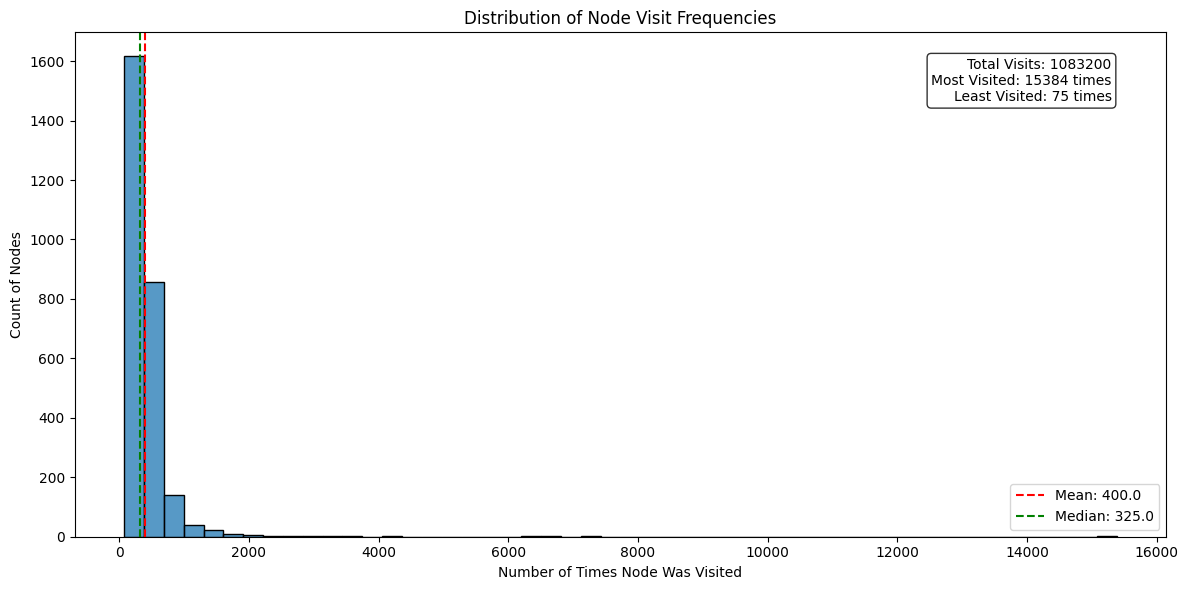

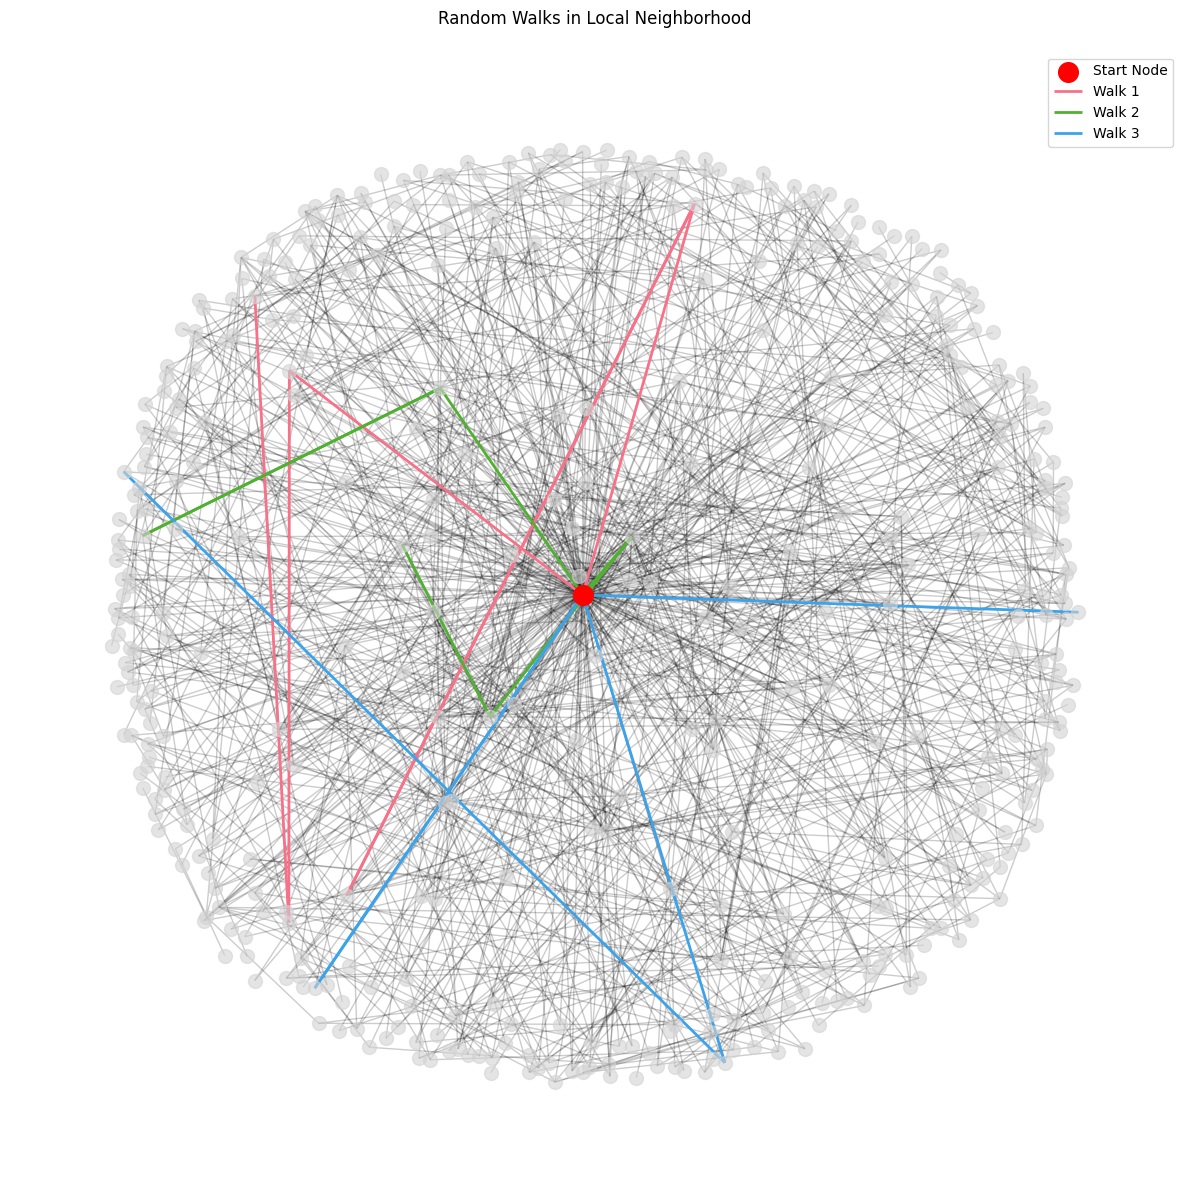

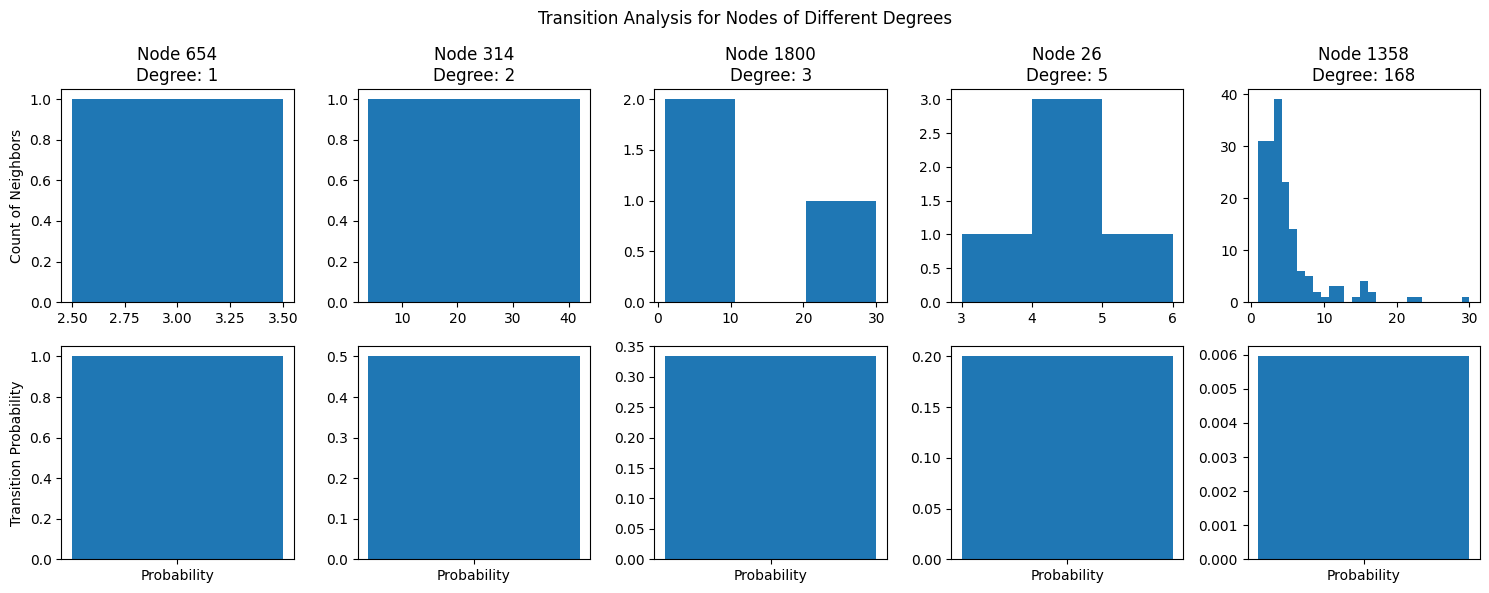

Starting training...
Epoch 1/5, Average Loss: 521.6376
Epoch 2/5, Average Loss: 82.5219
Epoch 3/5, Average Loss: 80.4987
Epoch 4/5, Average Loss: 80.8071
Epoch 5/5, Average Loss: 81.4839
Visualizing final embeddings...


C:\Users\pylan\AppData\Local\Temp\ipykernel_49632\2313779328.py:207: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([edge_sims, non_edge_sims], labels=['Connected', 'Not Connected'])


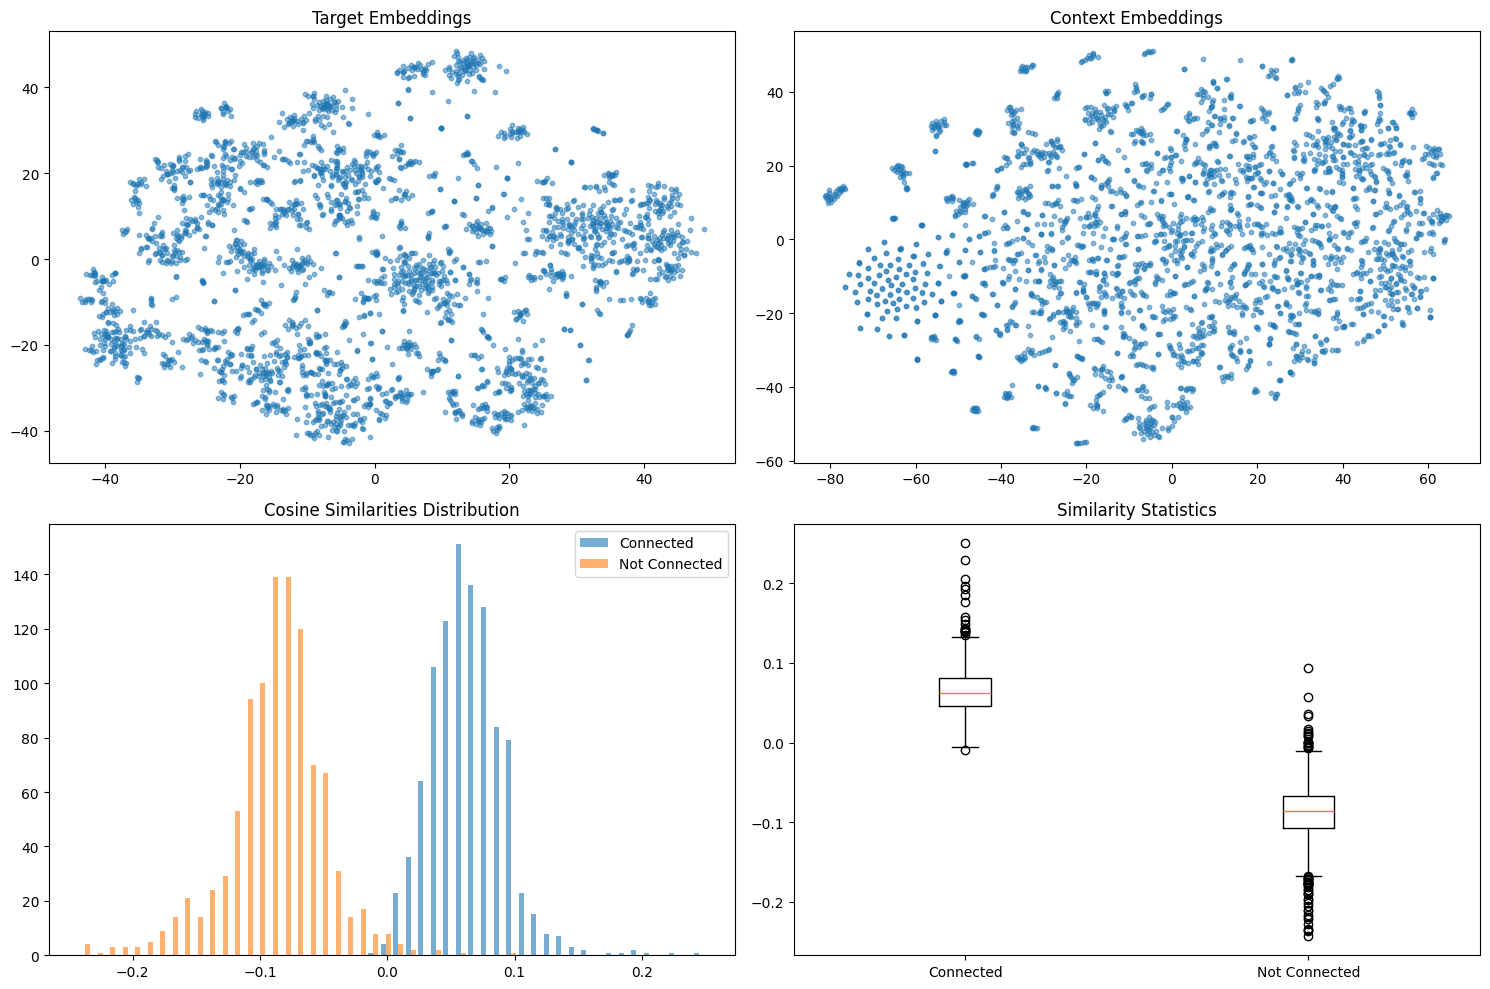

In [36]:
# Demonstrate different initializations
print("\nTraining with seed 42:")
model_42, analyzer_42 = train_deepwalk(seed=42)


Training with seed 123:
Using seed 123 for reproducible results
Successfully loaded Cora dataset with 2708 nodes and 10556 edges
Generating random walks...
Visualizing random walks...
Random Walk Statistics:
Number of walks: 27080
Walk lengths: min=40, max=40, mean=40.00
Coverage: 2708 out of 2708 nodes visited (100.0%)


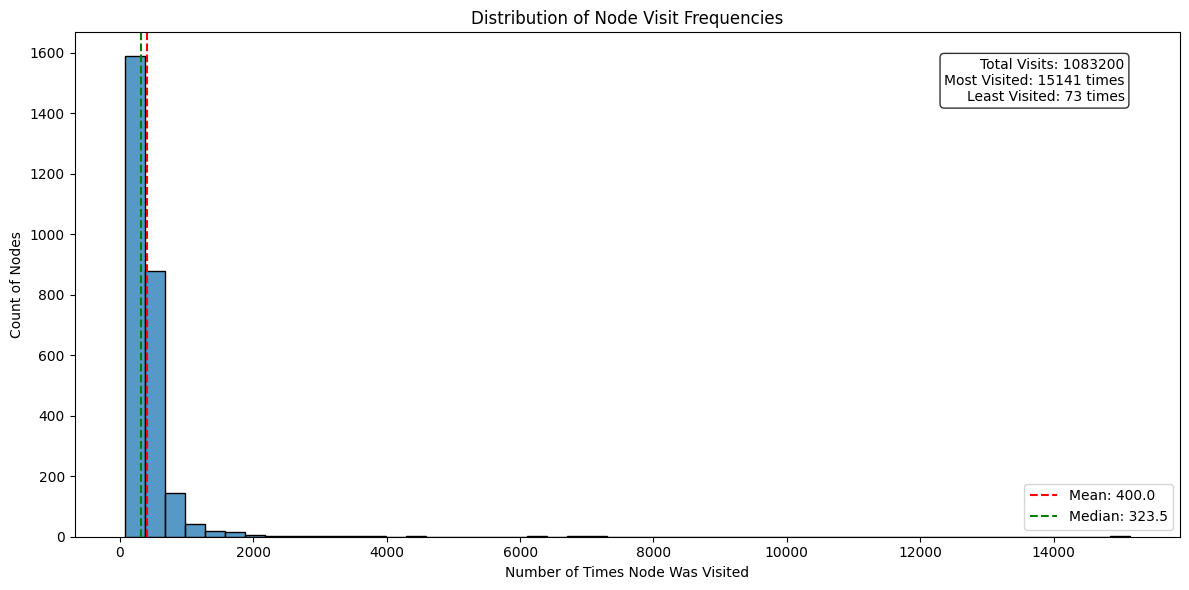

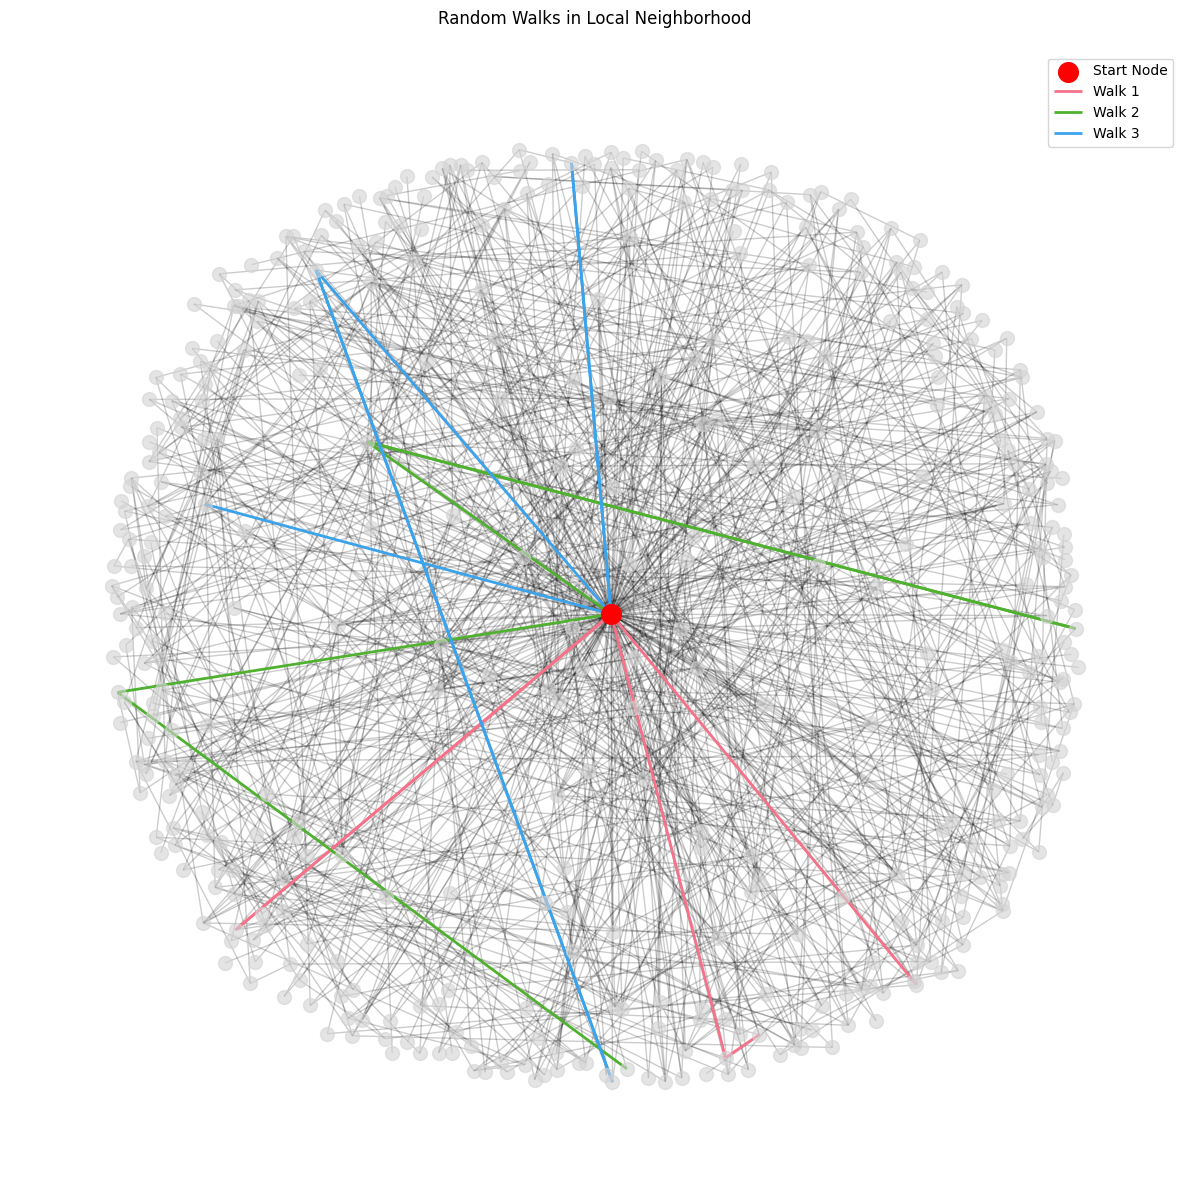

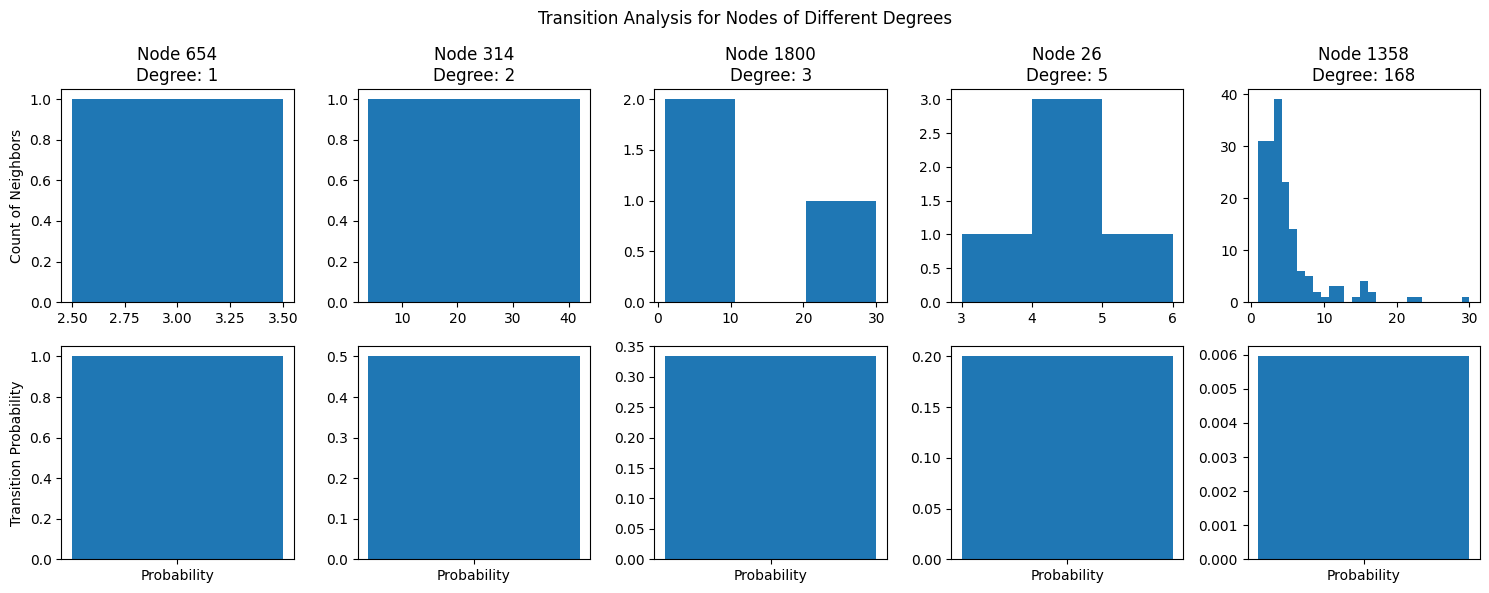

Starting training...


KeyboardInterrupt: 

In [35]:
print("\nTraining with seed 123:")
model_123, analyzer_123 = train_deepwalk(seed=123)

In [ ]:
print("\nTraining with random initialization:")
model_random, analyzer_random = train_deepwalk()

In [ ]:
# Optional: try with a historically more accurate optimizer and hyperparams instead of Adam, like
# In the train_deepwalk function, replace the optimizer setup:
initial_lr = 0.025
optimizer = optim.SGD(model.parameters(), lr=initial_lr)
# Create a linear learning rate scheduler
scheduler = optim.lr_scheduler.LinearLR(
    optimizer,
    start_factor=1.0,
    end_factor=0.0001,  # Nearly zero by the end
    total_iters=num_epochs * (len(positive_pairs) // batch_size)
)

# Then in the training loop, after optimizer.step():
scheduler.step()